# Simple Plotting


In [61]:
RESULTS_PATH = "../results/grads"

PLOT_ALL_SEEDS = False
# Full sweep
# MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "Qwen/Qwen-1_8B", "Qwen/Qwen-7B", "Qwen/Qwen-14B"]
MODELS_TO_PLOT = ["facebook/opt-350m", "Qwen/Qwen1.5-0.5B"]
# Minimal sweep
# MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large"]


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import display

import os
import glob
import json

In [63]:
records = []
for result_filename in glob.glob(os.path.join(RESULTS_PATH, "**/results_summary.json"), recursive=True):
    config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
    config = json.load(open(config_file, "r"))
    if config["model_size"] not in MODELS_TO_PLOT:
        continue
    if 'seed' not in config:
        config['seed'] = 0
    record = config.copy()
    if 'weak_model' in config:
        for k in record['weak_model']:
            if k == 'model_size':
                assert record['weak_model'][k] == record['weak_model_size']
            record['weak_' + k] = record['weak_model'][k]
        del record['weak_model']
    record.update(json.load(open(result_filename)))
    records.append(record)

df = pd.DataFrame.from_records(records).sort_values(['ds_name', 'model_size'])

Dataset: sciq_for_lm_head (seed: None)


/mnt/ssd-1/alexm/miniconda3/envs/w2s/lib/python3.11/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater



IndexError: index 0 is out of bounds for axis 0 with size 0

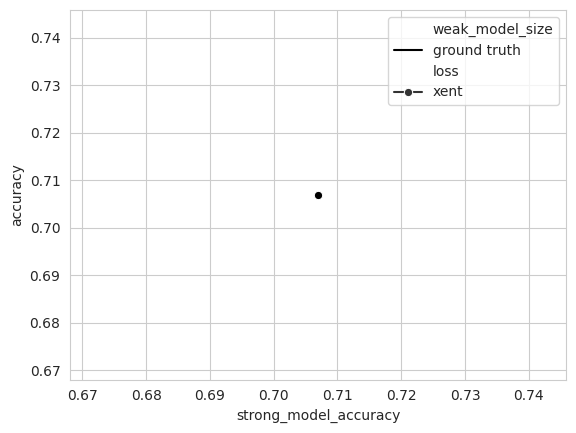

In [64]:
datasets = df.ds_name.unique()
for dataset in datasets:
    cur_df = df[(df.ds_name == dataset)].copy()
    base_accuracies = cur_df[cur_df['weak_model_size'].isna()].groupby('model_size').agg({'accuracy': 'mean', 'seed': 'count'}).sort_values('accuracy')
    base_accuracy_lookup = base_accuracies['accuracy'].to_dict()
    base_accuracies = base_accuracies.reset_index()

    cur_df['strong_model_accuracy'] = cur_df['model_size'].apply(lambda x: base_accuracy_lookup[x])
    cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_accuracy'] = cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_size'].apply(lambda x: base_accuracy_lookup[x])

    # Exclude cases where the weak model is better than the strong model from PGR calculation.
    valid_pgr_index = (
        (~cur_df['weak_model_size'].isna()) & 
        (cur_df['weak_model_size'] != cur_df['model_size']) & 
        (cur_df['strong_model_accuracy'] > cur_df['weak_model_accuracy'])
    )
    cur_df.loc[valid_pgr_index, 'pgr'] = (cur_df.loc[valid_pgr_index, 'accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy']) / (cur_df.loc[valid_pgr_index, 'strong_model_accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy'])

    cur_df.loc[cur_df['weak_model_size'].isna(), "weak_model_size"] = "ground truth"

    for seed in [None] + (sorted(cur_df['seed'].unique().tolist()) if PLOT_ALL_SEEDS else []):
        plot_df = cur_df.copy().sort_values(['strong_model_accuracy']).sort_values(['loss'], ascending=False)
        if seed is not None:
            plot_df = plot_df[plot_df['seed'] == seed]

        print(f"Dataset: {dataset} (seed: {seed})")

        pgr_results = plot_df[~plot_df['pgr'].isna()].groupby(['loss']).aggregate({"pgr": "median"})

        palette = sns.color_palette('colorblind', n_colors=len(plot_df['weak_model_size'].unique()) - 1)
        color_dict = {model: ("black" if model == 'ground truth' else palette.pop()) for model in plot_df['weak_model_size'].unique()}

        sns.lineplot(data=plot_df, x='strong_model_accuracy', y='accuracy', hue='weak_model_size', style='loss', markers=True, palette=color_dict)
        pd.plotting.table(plt.gca(), pgr_results.round(4), loc='lower right', colWidths=[0.1, 0.1], cellLoc='center', rowLoc='center')
        plt.xticks(ticks=base_accuracies['accuracy'], labels=[f"{e} ({base_accuracy_lookup[e]:.4f})" for e in base_accuracies['model_size']], rotation=90)
        plt.title(f"Dataset: {dataset} (seed: {seed})")
        plt.legend(loc='upper left')
        suffix = ""
        if seed is not None:
            suffix = f"_{seed}"
        plt.savefig(f"{dataset.replace('/', '-')}{suffix}.png", dpi=300, bbox_inches='tight')
        plt.show()

In [60]:
cur_df

,batch_size,max_ctx,ds_name,loss,n_train1_docs,n_train2_docs,n_test_docs,model_size,lr,optim,...,train_with_dropout,linear_probe,lr_schedule,gt_eval_every,load_best_model_at_end,metric_for_best_model,greater_is_better,save_total_limit,accuracy,disable_lora
1,32,512,sciq_for_lm_head_with_support,xent,3000,6000,1000,facebook/opt-350m,0.00004,adam,...,False,False,cosine_anneal,10000000,False,eval/auroc_against_supervision,True,50,0.908333,True


# Calibration w.r.t. the soft labels

In [46]:
import os
from datasets import load_from_disk
import numpy as np

# strong_path = "../results/conf_disagree/bs=32-dn=sciq_with_supp-ge=3-lp=0-l=xent-l=4e-05-ls=cosi_anne-mc=512-ms=Qwen1.5-0.5B-ntd=500-ntd=4300-ntd=4300-o=adam-s=0-twd=0"
# w2s_path = "../results/conf_disagree/bs=32-dn=sciq_with_supp-lp=0-l=kl-l=2e-05-ls=cosi_anne-mc=512-ms=Qwen1.5-0.5B-ntd=500-ntd=4300-ntd=4300-o=adam-s=0-see=15-twd=0-we=2-wlf=0.5-wms=opt-350m"
strong_path = "../results/grads/bs=32-dl=1-dn=sciq_for_lm_head_with_supp-gib=1-ge=3-gee=10000000-lp=0-lbmae=0-l=xent-l=4e-05-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=1000-ntd=3000-ntd=6000-o=adam-stl=50-s=0-twd=0"
w2s_path = "../results/grads/bs=32-dl=1-dn=sciq_for_lm_head_with_supp-gib=1-lp=0-lbmae=0-l=kl-l=2e-05-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=1000-ntd=3000-ntd=6000-o=adam-stl=50-s=0-twd=0-we=3-wee=25-wlf=0.5-wms=opt-350m"
eval_results_paths = [p for p in os.listdir(w2s_path) if p.startswith("eval_results") and p[-1].isdigit()]
eval_results_paths.sort(key=lambda x: int(x.split("_")[-1]))

weak_soft_labels = None
gt_labels = None
pred_probs = []
for p in eval_results_paths:
    eval_results = load_from_disk(os.path.join(w2s_path, p)).with_format("numpy")
    if weak_soft_labels is None:
        weak_soft_labels = eval_results['weak_soft_label'][:, 1]  # type: ignore
    else:
        assert np.all(weak_soft_labels == eval_results['weak_soft_label'][:, 1])  # type: ignore
    if gt_labels is None:
        gt_labels = eval_results['soft_label'][:, 1]  # type: ignore
    else:
        assert np.all(gt_labels == eval_results['soft_label'][:, 1])  # type: ignore
    pred_probs.append(eval_results['soft_pred'][:, 1])  # type: ignore

weak_soft_labels = np.array(weak_soft_labels)
pred_probs = np.array(pred_probs)
gt_labels = np.array(gt_labels)
weak_soft_labels.shape, pred_probs.shape, gt_labels.shape

((960,), (23, 960), (960,))

In [47]:
import plotly.graph_objs as go
import numpy as np

n_time_steps = len(pred_probs)
# Create base figure
fig = go.Figure(
    data=[go.Scatter(x=pred_probs[0], y=weak_soft_labels, mode='markers',  
                     marker=dict(color=gt_labels, colorscale='Viridis', colorbar=dict(title='GT Label')))],
    layout=go.Layout(
        title="Soft Labels Over Time",
        xaxis=dict(range=[0, 1], title="Strong student predicted probability"),
        yaxis=dict(range=[0, 1], title="Weak supervisor soft label"),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 700, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause",
                         method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                    ])]
    ),
    frames=[go.Frame(data=[go.Scatter(x=pred_probs[i], y=weak_soft_labels, mode='markers',
                                        marker=dict(color=gt_labels, colorscale='Viridis', colorbar=dict(title='GT Label')))],
                         name=str(i))
            for i in range(1, n_time_steps)]
)

# Add axis titles
fig.update_layout(xaxis_title="Strong student predicted probability", yaxis_title="Weak supervisor soft label", height=800, width=900)


# Show animation
fig.show()

# Get gradients per example

In [95]:
strong_eval_results_path = os.path.join(strong_path, "eval_results_final")
final_eval_results_path = os.path.join(w2s_path, "eval_results_final")
final_eval_results = load_from_disk(final_eval_results_path)
strong_eval_results = load_from_disk(strong_eval_results_path)
print(len(final_eval_results), len(strong_eval_results))
strong_eval_results = strong_eval_results.select(range(len(final_eval_results)))
assert np.all(np.array(final_eval_results['id']) == np.array(strong_eval_results['id']))
final_eval_results = final_eval_results.add_column("strong_soft_pred", strong_eval_results['soft_pred'])  # type: ignore
final_eval_results = final_eval_results.add_column("strong_hard_pred", strong_eval_results['hard_pred'])  # type: ignore
final_eval_results = final_eval_results.with_format("torch")

print("weak_hard_label acc", ((final_eval_results['weak_soft_label'][:, 1] > 0.5) == final_eval_results['hard_label']).float().mean())
print("strong_hard_pred acc", (final_eval_results['strong_hard_pred'] == final_eval_results['hard_label']).float().mean())
print("w2s pred acc", (final_eval_results['hard_pred'] == final_eval_results['hard_label']).float().mean())

FileNotFoundError: Directory ../results/grads/bs=32-dl=1-dn=sciq_for_lm_head_with_supp-gib=1-lp=0-lbmae=0-l=kl-l=2e-05-ls=cosi_anne-mc=512-mfbm=auro_agai_supe-ms=Qwen1.5-0.5B-ntd=1000-ntd=3000-ntd=6000-o=adam-stl=50-s=0-twd=0-we=3-wee=25-wlf=0.5-wms=opt-350m/eval_results_final not found

In [49]:
import json
from tqdm.auto import tqdm

import torch
from collections import defaultdict

from weak_to_strong.config import ModelConfig, MODELS_DICT, LOSS_DICT
from weak_to_strong.model import TransformerWithHead
from weak_to_strong.common import to_batch
from weak_to_strong.train import maybe_load_model

config = json.load(open(os.path.join(w2s_path, "config.json"), "r"))
model_name = config["model_size"]

In [37]:
use_lm_head = "choice_input_ids" in final_eval_results.column_names
loss_fn = LOSS_DICT[config["loss"]]

d_proj = 10_000
proj_grads, hiddens = defaultdict(lambda: defaultdict(dict)), defaultdict(lambda: defaultdict(dict))

In [50]:
proj_grads_path = os.path.join(w2s_path, "proj_grads.pt")
hiddens_path = os.path.join(w2s_path, "hiddens.pt")
if os.path.exists(proj_grads_path):
    proj_grads = torch.load(proj_grads_path)
    hiddens = torch.load(hiddens_path)
    print("Loaded existing proj_grads and hiddens")
else:
    for run_type, results_path in [("w2s", w2s_path), ("strong", strong_path),]:

        # init model
        mcfg = MODELS_DICT[model_name].copy()
        if config["disable_lora"]:
            mcfg["lora_modules"] = None
        model_config = ModelConfig(**mcfg)
        model = TransformerWithHead.from_pretrained(  # type: ignore
                    model_config.name,
                    lora_modules=model_config.lora_modules,
                    use_lm_head=use_lm_head,
                    num_labels=2,
                    linear_probe=config["linear_probe"],
                    **model_config.custom_kwargs,
                )

        model_n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        torch.manual_seed(0)  # ensure that our projection is the same across runs and examples
        proj_basis_indices = torch.randint(0, model_n_params, (d_proj,))
        print(f"Hash(projection indices): {proj_basis_indices.sum().item()}")
        
        for target_label_column in ["weak_soft_label", "soft_label"]:
            print(f"Computing gradients for {target_label_column} in {run_type}")
            for checkpoint in os.listdir(results_path):
                if not checkpoint.startswith("checkpoint") or run_type in proj_grads and checkpoint in proj_grads[run_type] and target_label_column in proj_grads[run_type][checkpoint]:
                    continue
                print(f"Loading model from {checkpoint}")
                proj_grads[run_type][checkpoint][target_label_column] = torch.zeros((len(final_eval_results), d_proj), device=model.device)
                hiddens[run_type][checkpoint][target_label_column] = torch.zeros((len(final_eval_results), model.config.hidden_size), device=model.device)

                # load model checkpoint
                assert maybe_load_model(model, os.path.join(results_path, checkpoint))
                model.eval().to("cuda:1").to(torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float32)

                for i, batch in tqdm(enumerate(to_batch(final_eval_results, batch_size=1))):
                    input_ids = torch.nn.utils.rnn.pad_sequence(
                                [ex for ex in batch["input_ids"]], batch_first=True
                        ).to(model.device)
                    label = batch[target_label_column].to(model.device)
                    choice_ids = batch.get("choice_input_ids")
                    logits, hs = model(
                                    input_ids, choice_input_ids=choice_ids.to(model.device) if choice_ids is not None else None, output_hidden_states=True
                        )
                        
                    loss = loss_fn(logits, label, step_frac=0)
                    loss.backward()

                    # get grad in a vector
                    grad = torch.cat([p.grad.clone().detach().flatten() for p in model.parameters() if p.requires_grad])
                    # project onto random direction
                    proj_grads[run_type][checkpoint][target_label_column][i, :] = grad[proj_basis_indices]
                    # proj_grads[i] = torch.cat([p.grad.clone().detach().flatten() for p in model.score.parameters() if p.requires_grad])

                    hiddens[run_type][checkpoint][target_label_column][i, :] = hs[-1][0, -1, :].detach().clone().cpu()

                    # zero out grads
                    model.zero_grad()
    
    def to_dict(defdict):
        return {k: to_dict(v) if isinstance(v, defaultdict) else v for k, v in defdict.items()}
    torch.save(to_dict(proj_grads), proj_grads_path)
    torch.save(to_dict(hiddens),hiddens_path)

Loaded existing proj_grads and hiddens


In [89]:
ckpt = "checkpoint_50.bin"
target_label_column = "weak_soft_label"
ckpt_grads = proj_grads["w2s"][ckpt][target_label_column]
# ckpt_hiddens = hiddens["w2s"][ckpt]

In [90]:
proj_grads_normalized = ckpt_grads / ckpt_grads.norm(dim=1, keepdim=True)

In [91]:
def get_answer_str(txt):
    last_quote = txt.rfind('"')
    penultimate_quote = txt.rfind('"', 0, last_quote)
    return txt[penultimate_quote + 1:last_quote]
is_answer_in_support = np.array([s.count(get_answer_str(s)) > 1 for s in final_eval_results["txt"]]) 
exists_support = np.array([not s.startswith("Name: Bob\n\nPassage 1:\n\n\nQ1:") for s in final_eval_results["txt"]])

In [92]:
soft_labels = np.array(final_eval_results["soft_label"])[:, 1]
weak_soft_labels = np.array(final_eval_results["weak_soft_label"])[:, 1]
strong_soft_preds = np.array(final_eval_results["strong_soft_pred"])[:, 1]
w2s_soft_preds = np.array(final_eval_results["soft_pred"])[:, 1]

weak_error = (weak_soft_labels - soft_labels)
weak_diff_from_strong = (weak_soft_labels - strong_soft_preds)

explained variance [0.7195876  0.02559572 0.02408537 0.01417299 0.01061273 0.00876744
 0.00667271 0.00544631 0.0046553  0.00458437]


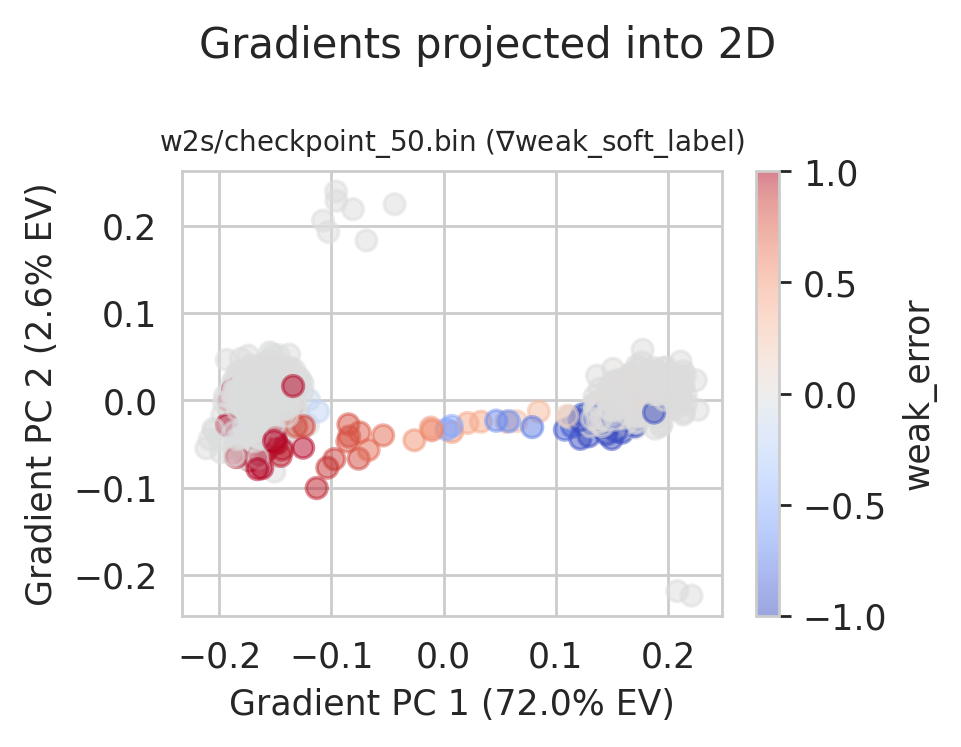

In [93]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('whitegrid')

# project gradients into 2D

use_normalized = False
mat = proj_grads_normalized if use_normalized else ckpt_grads
color = "weak_error"
pca = PCA(n_components=10)
proj_2d = pca.fit_transform(mat.cpu().numpy())
# proj_2d = pca.transform(mat.cpu().numpy())
print("explained variance", pca.explained_variance_ratio_)
plt.figure(figsize=(4, 3), dpi=250)
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c=locals()[color], cmap='coolwarm', alpha=0.5, marker='o', vmin=-1, vmax=1)
plt.colorbar(label=color)
evr1 = pca.explained_variance_ratio_[0]
evr2 = pca.explained_variance_ratio_[1]
plt.xlabel(f"Gradient PC 1 ({evr1 * 100:.1f}% EV)")
plt.ylabel(f"Gradient PC 2 ({evr2 * 100:.1f}% EV)")
plt.suptitle("Normalized gradients projected into 2D" if use_normalized else "Gradients projected into 2D")
plt.title(f"{run_type}/{ckpt} ($\\nabla${target_label_column})", fontsize=8)
plt.tight_layout()
plt.show()